In [30]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO
from io import StringIO
import tarfile
from sklearn.model_selection import train_test_split as split_sk
import surprise
from surprise import Dataset, SVD
from surprise.model_selection import cross_validate
#from surprise.model_selection import train_test_split
from surprise import accuracy, Dataset, SVD
from surprise.model_selection import GridSearchCV

In [2]:
dfit = pd.read_csv('jester_items.csv')
dfrt = pd.read_csv('jester_ratings.csv')

In [8]:
merged = pd.merge(dfrt, dfit, on='jokeId')
#merged = merged.reset_index(drop=True)
#merged["rating"] = merged["rating"].astype("float16")
#merged["jokeId"] = merged["jokeId"].astype("int16")
#merged["userId"] = merged["userId"].astype("int16")
#merged["jokeText"] = merged["jokeText"].astype("str")
merged.info()
merged.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1761439 entries, 0 to 1761438
Data columns (total 4 columns):
 #   Column    Dtype  
---  ------    -----  
 0   userId    int64  
 1   jokeId    int64  
 2   rating    float64
 3   jokeText  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 67.2+ MB


,userId,jokeId,rating,jokeText
0,1,5,0.219,Q.\tWhat's O. J. Simpson's Internet address? \...
1,2,5,-9.688,Q.\tWhat's O. J. Simpson's Internet address? \...
2,3,5,-9.844,Q.\tWhat's O. J. Simpson's Internet address? \...
3,4,5,-5.812,Q.\tWhat's O. J. Simpson's Internet address? \...
4,5,5,6.906,Q.\tWhat's O. J. Simpson's Internet address? \...


In [4]:
merged.shape

(1761439, 4)

C:\Users\franh\AppData\Local\Temp\ipykernel_22456\1532120522.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(merged.corr(), annot = True)


<Axes: >

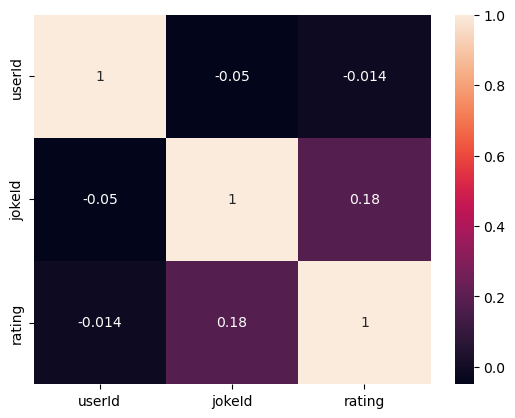

In [5]:
sns.heatmap(merged.corr(), annot = True)

## <b>3<span style='color:#F76251'>|</span> Data Preprocessing

In [40]:
# pivot the dataframe to create a matrix
matrix = merged.pivot(index = 'userId', columns = 'jokeId', values = 'rating').fillna(0)
matrix.head()

jokeId,5,7,8,13,15,16,17,18,19,20,...,141,142,143,144,145,146,147,148,149,150
userId,,,,,,,,,,,,,,,,,,,,,
1,0.219,-9.281,-9.281,-6.781,0.875,-9.656,-9.031,-7.469,-8.719,-9.156,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-9.688,9.938,9.531,9.938,0.406,3.719,9.656,-2.688,-9.562,-9.125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-9.844,-9.844,-7.219,-2.031,-9.938,-9.969,-9.875,-9.812,-9.781,-6.844,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-5.812,-4.500,-4.906,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6.906,4.750,-5.906,-0.406,-4.031,3.875,6.219,5.656,6.094,5.406,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
from scipy.sparse import csr_matrix
# CReating a spare matrix
nmatr = csr_matrix(matrix.values)

## KNN 

In [115]:
X = merged[['userId', 'jokeId', 'rating']]
y = merged['jokeText']

# Split data into 80% training set and 20% test set
X_train, X_test, y_train, y_test = split_sk(X, y, test_size=0.2, random_state=42)

# Split training data into 75% training set and 25% validation set
X_train, X_val, y_train, y_val = split_sk(X_train, y_train, test_size=0.20, random_state=42)


In [116]:
# Create sparse matrix for training set
train_matrix = pd.pivot_table(X_train, values='rating', index='userId', columns='jokeId')
train_matrix = csr_matrix(train_matrix.fillna(0))

# Create sparse matrix for validation set
val_matrix = pd.pivot_table(X_val, values='rating', index='userId', columns='jokeId')
val_matrix = csr_matrix(val_matrix.fillna(0))

# Create sparse matrix for test set
test_matrix = pd.pivot_table(X_test, values='rating', index='userId', columns='jokeId')
test_matrix = csr_matrix(test_matrix.fillna(0))


In [118]:
from sklearn.neighbors import NearestNeighbors

# Train the model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=5)
model_knn.fit(train_matrix)

# Find k-neighbors for each user in the validation set
distances, indices = model_knn.kneighbors(val_matrix, n_neighbors=5)

In [123]:
print('Indices of 5 nearest neighbors:', indices[:1])
print('Distances to 5 nearest neighbors:', distances[:1])

Indices of 5 nearest neighbors: [[  135 47924 57918 27260 54506]]
Distances to 5 nearest neighbors: [[0.46142869 0.48331927 0.49795378 0.50140056 0.509458  ]]


### Hyperparameter tunning

In [128]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

# Define the parameter grid to search
param_grid = {
    'n_neighbors': [10, 20, 30],
    'algorithm': ['brute', 'kd_tree'],
    'leaf_size': [10, 20, 30],
}

# Define a custom scorer that computes the mean squared error
def mse_scorer(estimator, X, y):
    distances, indices = estimator.kneighbors(X, n_neighbors=20)
    y_pred = []
    for i in range(len(indices)):
        jokes = indices[i]
        ratings = train_matrix[jokes, :].toarray()[0]
        y_pred.append(np.mean(ratings[ratings != 0]))
    return mean_squared_error(y, y_pred)

# Create the k-NN model
model_knn = NearestNeighbors(metric='cosine')

# Create the GridSearchCV object with the custom scorer
grid_search = GridSearchCV(model_knn, param_grid, cv=5, scoring=make_scorer(mse_scorer))

# Fit the GridSearchCV object on the training set
grid_search.fit(train_matrix)

# Print the best parameters found
print("Best parameters:", grid_search.best_params_)

Best parameters: {'algorithm': 'brute', 'leaf_size': 10, 'n_neighbors': 10}


In [129]:
# Evaluate the model performance on the test set using the best parameters found
best_model = grid_search.best_estimator_
distances, indices = best_model.kneighbors(test_matrix, n_neighbors=20)
y_pred = []
for i in range(len(indices)):
    jokes = indices[i]
    ratings = train_matrix[jokes, :].toarray()[0]
    y_pred.append(np.mean(ratings[ratings != 0]))
mse = mean_squared_error(y_test, y_pred)
print("Test set MSE:", mse)

ValueError: Found input variables with inconsistent numbers of samples: [352288, 52659]

Prueba con codigo de chatgpt para encontrar similitudes entre users, seguido de distancia y 3 peliculas 

In [113]:
# create a sparse matrix using userID as rows, movie_id as columns, and ratings as values
sparse_matrix = csr_matrix((merged["rating"], (merged["userId"], merged["jokeId"])))

# create a kNN model using cosine similarity
modelpt = NearestNeighbors(metric="cosine", algorithm="brute", n_neighbors=5)

# fit the model to the sparse matrix
modelpt.fit(sparse_matrix)

# select a user ID for which to find the nearest neighbors
query_user = 135

# find the indices and distances to the 10 nearest neighbors of the query user
distances, indices = modelpt.kneighbors(sparse_matrix[query_user], n_neighbors=5)

# print the titles of the movies that the nearest neighbors rated
print("Nearest neighbors of user", query_user)
for i in range(1, len(distances[0])): # The loop starts at 1 because the neighbor #1 is going to be the same user as selected in the query
    neighbor_user = indices[0][i]
    neighbor_distance = distances[0][i]
    neighbor_movies = merged.loc[merged["userId"] == neighbor_user]["jokeText"].values[:3] # limit to 3 movies as example 
    print("Neighbor", i+1, "- UserId:", neighbor_user, "- Distance:", neighbor_distance, "- Jokes:", neighbor_movies)

Nearest neighbors of user 135
Neighbor 2 - UserId: 3053 - Distance: 0.4916632629173475 - Jokes: ["How many feminists does it take to screw in a light bulb?\nThat's not funny.\n"
 'Q. Did you hear about the dyslexic devil worshiper? \n\nA. He sold his soul to Santa.\n'
 'They asked the Japanese visitor if they have elections in his\ncountry.  \n"Every Morning" he answers.\n']
Neighbor 3 - UserId: 28304 - Distance: 0.5108788972089806 - Jokes: ["How many feminists does it take to screw in a light bulb?\nThat's not funny.\n"
 'Q. Did you hear about the dyslexic devil worshiper? \n\nA. He sold his soul to Santa.\n'
 'They asked the Japanese visitor if they have elections in his\ncountry.  \n"Every Morning" he answers.\n']
Neighbor 4 - UserId: 426 - Distance: 0.5287445488721079 - Jokes: ["Q.\tWhat's O. J. Simpson's Internet address? \nA.\tSlash, slash, backslash, slash, slash, escape.\n"
 "How many feminists does it take to screw in a light bulb?\nThat's not funny.\n"
 'Q. Did you hear about

### SVD with Surprise pckg

 #### Performing SVD in a smaller dt

In [14]:
merged['userId'] = merged['userId'].astype(int) 
merged['jokeId'] = merged['jokeId'].astype(int)
merged['rating'] = merged['rating'].astype(float)  

In [132]:
# Transforming df into a Surprise specific data structure
reader = surprise.Reader(rating_scale=(1, 5))
svd_data = surprise.Dataset.load_from_df(merged[['userId', 'jokeId', 'rating']], reader)

In [133]:
from surprise.model_selection import train_test_split as split_surprise
# test set is made of 25% of the ratings.
trainset, testset = split_surprise(svd_data, test_size=0.25)
# We'll use the famous SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 4.7843


4.784262081488439

RMSE of 0.9169 is too high which menas that the model is not accurate.

### SVD Cross Validation

In [23]:
# Run 5-fold cross-validation and print results on based on the extracted final dataset
cross_validate(algo, svd_data, measures=["RMSE", "MAE"], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    4.7815  4.7805  4.7754  4.7850  4.7827  4.7810  0.0032  
MAE (testset)     3.7451  3.7432  3.7364  3.7505  3.7487  3.7448  0.0049  
Fit time          19.21   18.68   19.75   20.43   17.91   19.19   0.87    
Test time         3.04    3.14    3.18    3.90    3.08    3.27    0.32    


{'test_rmse': array([4.78154473, 4.78045803, 4.77539661, 4.78499974, 4.78272823]),
 'test_mae': array([3.74511646, 3.74321482, 3.73644876, 3.75053813, 3.74873793]),
 'fit_time': (19.210875511169434,
  18.680373430252075,
  19.745484828948975,
  20.432854175567627,
  17.905160665512085),
 'test_time': (3.0361342430114746,
  3.142449378967285,
  3.1804862022399902,
  3.8995702266693115,
  3.0834622383117676)}

### SVD (training the model on the whole dataset) 

In [134]:
# Training the model
svd_algo = surprise.SVD()
trainset = svd_data.build_full_trainset()
svd_algo.fit(trainset)

In [136]:
# Recommending 5 movies to x user
x = 30878 # userID number
k = 5 # Number of movies that are going to be recommended

# recommend top-k movies for a given user
user_items = trainset.ur[trainset.to_inner_uid(x)]
not_watched = [item_id for item_id in trainset.all_items() if item_id not in user_items]
predictions = [svd_algo.predict(x, item_id) for item_id in not_watched]
top_k_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)[:k]
recommended_titles = [merged[merged['jokeId'] == pred.iid]['jokeText'].iloc[0] for pred in top_k_predictions]

# print the recommended movie titles
print(recommended_titles)

['If pro- is the opposite of con- then congress must be the opposite\nof progress.\n', 'A lady bought a new Lexus. It cost a bundle. Two days later, she brought it back, complaining that the radio was not working. "Madam," said the sales manager, "the audio system in this car is completely automatic. All you need to do is tell it what you want to listen to, and you will hear exactly that!" She drove out, somewhat amazed and a little confused. She looked at the radio and said, "Nelson." The radio responded, "Ricky or Willie?" She was astounded. If she wanted Beethoven, that\'s what she got. If she wanted Nat King Cole, she got it. She was stopped at a traffic light enjoying "On the Road Again" when the light turned green and she pulled out. Suddenly an enormous sports utility vehicle coming from the street she was crossing sped toward her, obviously not paying attention to the light. She swerved and narrowly missed a collision. "Idiot!" she yelled and, from the radio, "Ladies and gentle

#### Tune algorithm parameters with GridSearchCV

Evaluating the average RMSE and MAE over a 3-fold cross-validation procedure

In [138]:
param_grid = {"n_epochs": [5, 10], "lr_all": [0.002, 0.005], "reg_all": [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3)

gs.fit(svd_data)

# best RMSE score
print(gs.best_score["rmse"])

# combination of parameters that gave the best RMSE score
print(gs.best_params["rmse"])

TypeError: GridSearchCV.__init__() got an unexpected keyword argument 'measures'

In [ ]:
# We can now use the algorithm that yields the best rmse:
best_algo = gs.best_estimator["rmse"]
best_algo.fit(svd_data.build_full_trainset())

### Using best model for recommendations

In [ ]:
# Recommending 5 movies to x user
x = 30878 # userID number
k = 5 # Number of movies that are going to be recommended

# recommend top-k movies for a given user
user_items = trainset.ur[trainset.to_inner_uid(x)]
not_watched = [item_id for item_id in trainset.all_items() if item_id not in user_items]
predictions = [best_algo.predict(x, item_id) for item_id in not_watched]
top_k_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)[:k]
recommended_titles = [final_df[final_df['movie_id'] == pred.iid]['title'].iloc[0] for pred in top_k_predictions]

# print the recommended movie titles
print(recommended_titles)

['Alias: Season 1', 'Inu-Yasha: The Movie 3: Swords of an Honorable Ruler', 'Six Feet Under: Season 4', 'Harakiri', 'As Time Goes By: Series 8']
